In [40]:
from dataclasses import dataclass
from enum import Enum
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np

from gps_accuracy.gps_accuracy import GpxResult
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [248]:
from gps_accuracy.gps_accuracy import GpxEvaluator
import pandas as pd

class InputType(Enum):
    Touch = 1
    TUI = 2
    
class Metaphor(Enum):
    Gesture = 1
    Joystick = 2
    Car =  3
    
@dataclass
class ReferenceTrack:
    track_id: int
    file: Path
    
    def __init__(self, file_path: Path):
        self.track_id = int(file_path.stem)
        self.file = file_path

@dataclass
class RecordedTrack:
    track_id: int
    user_id: int
    input_type: InputType
    metaphor: Metaphor
    file: Path
    result: GpxResult
    
    def __init__(self, file_path: Path):
        file_name = file_path.stem
        parts = file_name.split("_")
        self.track_id: int = int(parts[0])
        self.user_id: int = int(parts[1])
        self.input_type: InputType = InputType[parts[2]]
        self.metaphor: Metaphor = Metaphor[parts[3]]
        self.file: Path = file_path
    
    def evaluate(self, reference_track: ReferenceTrack):
        evaluator = GpxEvaluator(reference_track.file, self.file)
        self.result = evaluator.evaluate()
              
@dataclass
class TrackRepository:
    reference_tracks: dict
    recorded_tracks: List[RecordedTrack]
    
    def __init__(self):
        reference_track_list = [ReferenceTrack(track_file) for track_file in Path("reference_tracks").iterdir() if track_file.is_file()]
        self.reference_tracks = {track.track_id: track for track in reference_track_list}
        self.recorded_tracks = [RecordedTrack(track_file) for track_file in Path("recorded_tracks").iterdir() if track_file.is_file()]
        self._evaluate() 
    
    def _evaluate(self):
        for track in self.recorded_tracks:
            reference_track = self.reference_tracks[track.track_id]
            track.evaluate(reference_track)
        
    def get_by_track(self, track_id: int) -> List[RecordedTrack]:
        return [track for track in self.recorded_tracks if track.track_id == track_id]

    def get_by_user(self, user_id: int) -> List[RecordedTrack]:
        return [track for track in self.recorded_tracks if track.user_id == user_id]
    
    def get_by_input_type(self, input_type: InputType) -> List[RecordedTrack]:
        return [track for track in self.recorded_tracks if track.input_type == input_type]
    
    def get_by_metaphor(self, metaphor: Metaphor) -> List[RecordedTrack]:
        return [track for track in self.recorded_tracks if track.metaphor == metaphor]
    
    def get_all(self) -> List[RecordedTrack]:
        return self.recorded_tracks

class InputFilter(Enum):
    InputAll = 1
    InputCategorized = 2
    
class ResultParam(Enum):
    Time = 1
    MeanError = 2
    MedianError = 3
    PercentileError = 4

class ResultPlotter:
    def __init__(self):
        self.repo = TrackRepository()
        tracks = self.repo.get_all()
        data = {
            'Track':  [track.track_id for track in tracks],
            'InputAll': [f"{track.input_type.name}_{track.metaphor.name}" for track in tracks],
            'InputCategorized': [track.input_type.name for track in tracks],
            'Time': [track.result.time for track in tracks],
            'MeanError': [track.result.mean for track in tracks],
            'MedianError': [track.result.median for track in tracks],
            'PercentileError': [track.result.percentile for track in tracks]
        }
        self.data_frame = pd.DataFrame(data)
        self.data_frame.style.format(precision=2, decimal=".")
    
    def print_result(self, result_param: ResultParam, input_filter: InputFilter, plot = False):
        table = self.data_frame.pivot_table(index="Track", columns=input_filter.name, values=result_param.name)
        if plot:
            plt.figure()
            table.plot.bar()
        return table.style.format(precision=2).background_gradient(axis=1, cmap='Greens')
    

In [249]:
plotter = ResultPlotter()

InputAll,TUI_Car,TUI_Joystick,Touch_Gesture,Touch_Joystick
Track,,,,
1,59.00,73.00,82.00,50.00
2,145.00,127.00,154.00,122.00
3,212.00,216.00,173.00,170.00
4,88.00,113.00,130.00,95.00


<Figure size 640x480 with 0 Axes>

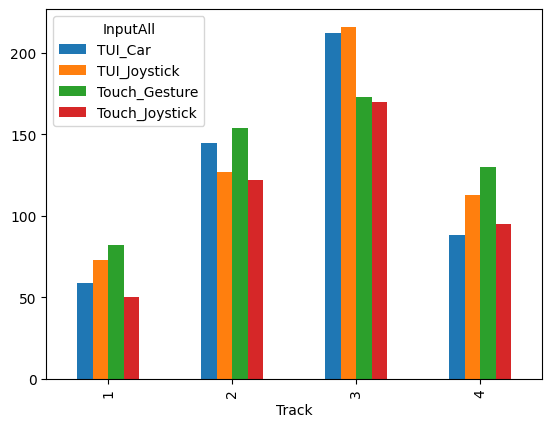

In [250]:
plotter.print_result(ResultParam.Time, InputFilter.InputAll, plot=True) # Time in seconds

In [243]:
plotter.print_result(ResultParam.MeanError, InputFilter.InputAll, plot=False) # Mean Error in meter

InputAll,TUI_Car,TUI_Joystick,Touch_Gesture,Touch_Joystick
Track,,,,
1,1.31,1.35,1.53,1.62
2,1.46,1.45,1.32,1.91
3,1.40,1.28,1.58,1.93
4,2.22,1.56,1.31,1.82


In [245]:
plotter.print_result(ResultParam.Time, InputFilter.InputCategorized, plot=False) # Time in seconds

InputCategorized,TUI,Touch
Track,,
1,66.00,66.00
2,136.00,138.00
3,214.00,171.50
4,100.50,112.50


In [246]:
plotter.print_result(ResultParam.MeanError, InputFilter.InputCategorized, plot=False) # Mean Error in meter

InputCategorized,TUI,Touch
Track,,
1,1.33,1.58
2,1.45,1.62
3,1.34,1.76
4,1.89,1.56
